In [1]:
!pip install scikit-learn
import numpy as np 
import random
import tqdm
import matplotlib.pyplot as plt # Graphical library
from sklearn.metrics import mean_squared_error # Mean-squared error function

# Coursework 1 :
See pdf for instructions. 

In [2]:
# WARNING: fill in these two functions that will be used by the auto-marking script
# [Action required]

def get_CID():
  return "02285087" # Return your CID (add 0 at the beginning to ensure it is 8 digits long)

def get_login():
  return "ldb22" # Return your short imperial login

## Helper class

In [3]:
# This class is used ONLY for graphics
# YOU DO NOT NEED to understand it to work on this coursework

class GraphicsMaze(object):

  def __init__(self, shape, locations, default_reward, obstacle_locs, absorbing_locs, absorbing_rewards, absorbing):

    self.shape = shape
    self.locations = locations
    self.absorbing = absorbing

    # Walls
    self.walls = np.zeros(self.shape)
    for ob in obstacle_locs:
      self.walls[ob] = 20

    # Rewards
    self.rewarders = np.ones(self.shape) * default_reward
    for i, rew in enumerate(absorbing_locs):
      self.rewarders[rew] = 10 if absorbing_rewards[i] > 0 else -10

    # Print the map to show it
    self.paint_maps()

  def paint_maps(self):
    """
    Print the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders)
    plt.show()

  def paint_state(self, state):
    """
    Print one state on the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    states = np.zeros(self.shape)
    states[state] = 30
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders + states)
    plt.show()

  def draw_deterministic_policy(self, Policy):
    """
    Draw a deterministic policy
    input: Policy {np.array} -- policy to draw (should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, action in enumerate(Policy):
      if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
        continue
      arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
      action_arrow = arrows[action] # Take the corresponding action
      location = self.locations[state] # Compute its location on graph
      plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    plt.show()

  def draw_policy(self, Policy):
    """
    Draw a policy (draw an arrow in the most probable direction)
    input: Policy {np.array} -- policy to draw as probability
    output: /
    """
    deterministic_policy = np.array([np.argmax(Policy[row,:]) for row in range(Policy.shape[0])])
    self.draw_deterministic_policy(deterministic_policy)

  def draw_value(self, Value):
    """
    Draw a policy value
    input: Value {np.array} -- policy values to draw
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, value in enumerate(Value):
      if(self.absorbing[0, state]): # If it is an absorbing state, don't plot any value
        continue
      location = self.locations[state] # Compute the value location on graph
      plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    plt.show()

  def draw_deterministic_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple deterministic policies
    input: Policies {np.array of np.array} -- array of policies to draw (each should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Policies)): # Go through all policies
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, action in enumerate(Policies[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
          continue
        arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
        action_arrow = arrows[action] # Take the corresponding action
        location = self.locations[state] # Compute its location on graph
        plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graph given as argument
    plt.show()

  def draw_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policies (draw an arrow in the most probable direction)
    input: Policy {np.array} -- array of policies to draw as probability
    output: /
    """
    deterministic_policies = np.array([[np.argmax(Policy[row,:]) for row in range(Policy.shape[0])] for Policy in Policies])
    self.draw_deterministic_policy_grid(deterministic_policies, title, n_columns, n_lines)

  def draw_value_grid(self, Values, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policy values
    input: Values {np.array of np.array} -- array of policy values to draw
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Values)): # Go through all values
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, value in enumerate(Values[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
          continue
        location = self.locations[state] # Compute the value location on graph
        plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
    plt.show()


## Maze class

In [4]:
# This class define the Maze environment

class Maze(object):

  # [Action required]
  def __init__(self):
    """
    Maze initialisation.
    input: /
    output: /
    """
    
    y = 8
    z = 7

    
    # [Action required]
    # Properties set from the CID
    self._prob_success = 0.8 + 0.02 * (9 - y) # float
    #self._prob_success = 0.25
    self._gamma = 0.8 + 0.02 * y # float
    #self._gamma = 0.75
    self._goal = z % 4 # integer, here I have R3 (0 for R0, 1 for R1, 2 for R2, 3 for R3)

    # Build the maze
    self._build_maze()
                              

  # Functions used to build the Maze environment 
  # You DO NOT NEED to modify them
  def _build_maze(self):
    """
    Maze initialisation.
    input: /
    output: /
    """

    # Properties of the maze
    self._shape = (13, 10)
    self._obstacle_locs = [
                          (1,0), (1,1), (1,2), (1,3), (1,4), (1,7), (1,8), (1,9), \
                          (2,1), (2,2), (2,3), (2,7), \
                          (3,1), (3,2), (3,3), (3,7), \
                          (4,1), (4,7), \
                          (5,1), (5,7), \
                          (6,5), (6,6), (6,7), \
                          (8,0), \
                          (9,0), (9,1), (9,2), (9,6), (9,7), (9,8), (9,9), \
                          (10,0)
                         ] # Location of obstacles
    self._absorbing_locs = [(2,0), (2,9), (10,1), (12,9)] # Location of absorbing states
    self._absorbing_rewards = [ (500 if (i == self._goal) else -50) for i in range (4) ]
    self._starting_locs = [(0,0), (0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9)] #Reward of absorbing states
    self._default_reward = -1 # Reward for each action performs in the environment
    self._max_t = 500 # Max number of steps in the environment

    # Actions
    self._action_size = 4
    self._direction_names = ['N','E','S','W'] # Direction 0 is 'N', 1 is 'E' and so on
        
    # States
    self._locations = []
    for i in range (self._shape[0]):
      for j in range (self._shape[1]):
        loc = (i,j) 
        # Adding the state to locations if it is no obstacle
        if self._is_location(loc):
          self._locations.append(loc)
    self._state_size = len(self._locations)

    # Neighbours - each line is a state, ranked by state-number, each column is a direction (N, E, S, W)
    self._neighbours = np.zeros((self._state_size, 4)) 
    
    for state in range(self._state_size):
      loc = self._get_loc_from_state(state)

      # North
      neighbour = (loc[0]-1, loc[1]) # North neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('N')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('N')] = state

      # East
      neighbour = (loc[0], loc[1]+1) # East neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('E')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('E')] = state

      # South
      neighbour = (loc[0]+1, loc[1]) # South neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('S')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('S')] = state

      # West
      neighbour = (loc[0], loc[1]-1) # West neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('W')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('W')] = state

    # Absorbing
    self._absorbing = np.zeros((1, self._state_size))
    for a in self._absorbing_locs:
      absorbing_state = self._get_state_from_loc(a)
      self._absorbing[0, absorbing_state] = 1

    # Transition matrix
    self._T = np.zeros((self._state_size, self._state_size, self._action_size)) # Empty matrix of domension S*S*A
    for action in range(self._action_size):
      for outcome in range(4): # For each direction (N, E, S, W)
        # The agent has prob_success probability to go in the correct direction
        if action == outcome:
          prob = 1 - 3.0 * ((1.0 - self._prob_success) / 3.0) # (theoritically equal to self.prob_success but avoid rounding error and garanty a sum of 1)
        # Equal probability to go into one of the other directions
        else:
          prob = (1.0 - self._prob_success) / 3.0
          
        # Write this probability in the transition matrix
        for prior_state in range(self._state_size):
          # If absorbing state, probability of 0 to go to any other states
          if not self._absorbing[0, prior_state]:
            post_state = self._neighbours[prior_state, outcome] # Post state number
            post_state = int(post_state) # Transform in integer to avoid error
            self._T[prior_state, post_state, action] += prob

    # Reward matrix
    self._R = np.ones((self._state_size, self._state_size, self._action_size)) # Matrix filled with 1
    self._R = self._default_reward * self._R # Set default_reward everywhere
    for i in range(len(self._absorbing_rewards)): # Set absorbing states rewards
      post_state = self._get_state_from_loc(self._absorbing_locs[i])
      self._R[:,post_state,:] = self._absorbing_rewards[i]

    # Creating the graphical Maze world
    self._graphics = GraphicsMaze(self._shape, self._locations, self._default_reward, self._obstacle_locs, self._absorbing_locs, self._absorbing_rewards, self._absorbing)
    
    # Reset the environment
    self.reset()


  def _is_location(self, loc):
    """
    Is the location a valid state (not out of Maze and not an obstacle)
    input: loc {tuple} -- location of the state
    output: _ {bool} -- is the location a valid state
    """
    if (loc[0] < 0 or loc[1] < 0 or loc[0] > self._shape[0]-1 or loc[1] > self._shape[1]-1):
      return False
    elif (loc in self._obstacle_locs):
      return False
    else:
      return True


  def _get_state_from_loc(self, loc):
    """
    Get the state number corresponding to a given location
    input: loc {tuple} -- location of the state
    output: index {int} -- corresponding state number
    """
    return self._locations.index(tuple(loc))


  def _get_loc_from_state(self, state):
    """
    Get the state number corresponding to a given location
    input: index {int} -- state number
    output: loc {tuple} -- corresponding location
    """
    return self._locations[state]

  # Getter functions used only for DP agents
  # You DO NOT NEED to modify them
  def get_T(self):
    return self._T

  def get_R(self):
    return self._R

  def get_absorbing(self):
    return self._absorbing

  # Getter functions used for DP, MC and TD agents
  # You DO NOT NEED to modify them
  def get_graphics(self):
    return self._graphics

  def get_action_size(self):
    return self._action_size

  def get_state_size(self):
    return self._state_size

  def get_gamma(self):
    return self._gamma

  # Functions used to perform episodes in the Maze environment
  def reset(self):
    """
    Reset the environment state to one of the possible starting states
    input: /
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """
    self._t = 0
    self._state = self._get_state_from_loc(self._starting_locs[random.randrange(len(self._starting_locs))])
    self._reward = 0
    self._done = False
    return self._t, self._state, self._reward, self._done

  def step(self, action):
    """
    Perform an action in the environment
    input: action {int} -- action to perform
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """

    # If environment already finished, print an error
    if self._done or self._absorbing[0, self._state]:
      print("Please reset the environment")
      return self._t, self._state, self._reward, self._done

    # Drawing a random number used for probaility of next state
    probability_success = random.uniform(0,1)

    # Look for the first possible next states (so get a reachable state even if probability_success = 0)
    new_state = 0
    while self._T[self._state, new_state, action] == 0: 
      new_state += 1
    assert self._T[self._state, new_state, action] != 0, "Selected initial state should be probability 0, something might be wrong in the environment."

    # Find the first state for which probability of occurence matches the random value
    total_probability = self._T[self._state, new_state, action]
    while (total_probability < probability_success) and (new_state < self._state_size-1):
     new_state += 1
     total_probability += self._T[self._state, new_state, action]
    assert self._T[self._state, new_state, action] != 0, "Selected state should be probability 0, something might be wrong in the environment."
    
    # Setting new t, state, reward and done
    self._t += 1
    self._reward = self._R[self._state, new_state, action]
    self._done = self._absorbing[0, new_state] or self._t > self._max_t
    self._state = new_state
    return self._t, self._state, self._reward, self._done

## DP Agent

In [5]:
# This class define the Dynamic Programing agent 
# "taken from lab assignment 2"
class DP_agent(object):

  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
    
    def value_iteration(self, env, gamma, threshold = 0.00001):
        """
        Value iteration on GridWorld
        input:
          - env {Maze} -- Our world/environment
          - gamma {float} -- Our discount factor
          - threshold {float} -- threshold value used to stop the value iteration algorithm
        output:
          - opt_policy {np.array} -- optimal policy found using the value iteration algorithm
          - V {np.array} -- value function corresponding to the policy
          - n_epoch {int} -- number of epochs to find this optimal policy
        """
        
        # Initialisation
        delta = threshold  # Setting value of delta to go through the first breaking condition
        T = env.get_T() # Transition matrix with probabilities
        R = env.get_R() #Reward matrix
        absorbing = env.get_absorbing() # Maze with 0 and 1 depending on absorbing (1) or not (0)
        state_size = env.get_state_size() # Number of states
        action_size = env.get_action_size() # Number of actions
        n_epoch = 0 # Number of iterations       
        V = np.zeros(state_size) # Initialising value function to 0
        policy = np.zeros((state_size, state_size))  # Initialising policy to 0

        while delta >= threshold: # Looping until the terminating condition 
            
            delta = 0  # Initialization of delta
            n_epoch += 1 # Incrementing the number of iterations

            for previous_state in range(state_size): # Looping over each previous state

                if absorbing[0, previous_state] == 0: # Ensure the state is non-absorbing

                    store_V = V[previous_state] # Storing the value of this state

                    adjacent_Q = np.zeros(action_size) 
                    
                    for next_state in range(state_size): # Looping over each next state
                        
                        adjacent_Q += T[previous_state, next_state, :] * (R[previous_state, next_state, :] + gamma * V[next_state])

                    V[previous_state] = np.max(adjacent_Q) # Seting the new value to the maximum of all actions                   
                    delta = max(delta, np.abs(store_V - V[previous_state])) # Calculating new delta

        opt_policy = np.zeros((state_size, state_size))  # Initialisation of our optimal policy

        for previous_state in range(state_size): # Looping over each previous state
            
            adjacent_Q = np.zeros(action_size) 
            
            for next_state in range(state_size): # Looping over each next state
                
                adjacent_Q += T[previous_state, next_state, :] * (R[previous_state, next_state, :] + gamma * V[next_state])
            
            opt_policy[previous_state, np.argmax(adjacent_Q)] = 1 # The action that maximises the Q value gets probability 1
        
        return opt_policy, V, n_epoch 
    
    def policy_evaluation(self, policy, env, gamma, threshold = 0.00001):
        """
        Policy evaluation on GridWorld
        input:
          - policy {np.array} -- policy to evaluate
          - env {Maze} -- Our world/environment
          - gamma {float} -- Our discount factor
          - threshold {float} -- threshold value used to stop the policy evaluation algorithm
        output:
          - V {np.array} -- value function corresponding to the policy
          - n_epoch {int} -- number of epochs to find this value function
        """
        
        # Initialisation  
        delta = 2 * threshold # Respect condition to start
        T = env.get_T() # Transition matrix with probabilities
        R = env.get_R() #Reward matrix
        absorbing = env.get_absorbing() # Maze with 0 and 1 depending on absorbing (1) or not (0)
        state_size = env.get_state_size() # Number of states
        action_size = env.get_action_size() # Number of actions
        n_epoch = 0 # Number of iterations
        V  = np.zeros(state_size) # Initialise value function to 0
        Vnew = np.copy(V) # Make a deep copy of the value array to hold the update during the evaluation
        
        while delta > threshold: # Looping until the terminating condition
            
            n_epoch += 1 # Incrementing the number of iterations
            
            for previous_state in range(state_size): # Looping over each previous state
                
                if absorbing[0, previous_state] == 0: # Ensure the state is non-absorbing
                    
                    adjacent_V = 0
                    
                    for action in range(action_size): # Looping over each action
                        
                        adjacent_Q = 0
                        
                        for next_state in range(state_size): # Looping over each next state
                            
                            adjacent_Q += T[previous_state, next_state, action] * (R[previous_state, next_state, action] + gamma * V[next_state])
                        
                        adjacent_V += policy[previous_state,action] * adjacent_Q # Evaluation of our value function for each action
                    
                    Vnew[previous_state] = adjacent_V # Update the value of the state

            delta = max(abs(V - Vnew)) # Calculating new delta
            
            V = np.copy(Vnew) # Update V

        return V, n_epoch

    def policy_iteration(self, env, gamma, threshold = 0.00001):
        """
        Policy iteration on GridWorld
        input:
          - env {Maze} -- Our world/environment
          - gamma {float} -- Our discount factor
          - threshold {float} -- threshold value used to stop the policy iteration algorithm
        output:
          - policy {np.array} -- policy found using the policy iteration algorithm
          - V {np.array} -- value function corresponding to the policy
          - n_epoch {int} -- number of epochs to find this policy
        """
       
        # Initialisation  
        T = env.get_T() # Transition matrix with probabilities
        R = env.get_R() #Reward matrix
        absorbing = env.get_absorbing() # Maze with 0 and 1 depending on absorbing (1) or not (0)
        state_size = env.get_state_size() # Number of states
        action_size = env.get_action_size() # Number of actions
        n_epoch = 0 # Number of iterations
        V = np.zeros(state_size) # Initialising value function to 0
        policy = np.zeros((state_size, action_size)) # Initialising policy to 0
        policy[:, 0] = 1  # Initialise policy to choose action 1 systematically
        policy_stable = False  # Condition to stop the main loop
        
        while not policy_stable: # Until we find a policy that converges properly
            
            V, n_epochs_V = self.policy_evaluation(policy, env, gamma, threshold) # Using function defined above
            n_epoch += n_epochs_V # Incrementing the number of iterations
            policy_stable = True # it will be set to False later if the policy prove unstable

            for previous_state in range(state_size): # Looping over each previous state
                
                if absorbing[0, previous_state] == 0: # Ensure the state is non-absorbing
                    
                    previous_action = np.argmax(policy[previous_state, :]) # Store the old action (used for convergence criterion)
                    adjacent_Q = np.zeros(action_size)

                    for next_state in range(state_size): # Looping over each next state
                        
                        adjacent_Q += T[previous_state, next_state, :] * (R[previous_state, next_state, :] + gamma * V[next_state])

                    best_action = np.argmax(adjacent_Q) # We keep the index of the highest value
                    new_policy = np.zeros(action_size)
                    new_policy[best_action] = 1  # The action that maximises the Q value gets probability 1
                    policy[previous_state, :] = new_policy # Adding to general policy

                    if previous_action != best_action:  # Checking if the policy has converged
                        
                        policy_stable = False # We indicate that our current policy did not converge so we still run the algorithm
        
        return policy, V, n_epoch   
    
    def solve(self, env):
        """
        Solve a given Maze environment using Dynamic Programming
        input: 
          - env {Maze} -- Our world/environment
        output:
          - policy {np.array} -- Optimal policy found to solve the given Maze environment
          - V {np.array} -- Corresponding value function
        """

        # Initialisation
        state_size = env.get_state_size() # Number of states
        action_size = env.get_action_size() # Number of actions
        gamma = env._gamma # Discount factor
        policy = np.zeros((state_size, action_size)) # Initialising policy to 0
        V = np.zeros(state_size) # Initialising value function to 0

        """
        Process with Value Iteration algorithm
        """
        policy, V, n_epoch = self.value_iteration(env, gamma)
        #print('Final number of epochs for Value Iteration : ', n_epoch, '\n')
        
        """
        Process with Policy Iteration algorithm
        """
        #policy, V, n_epoch = self.policy_iteration(env, gamma)
        #print('Final number of epochs for Policy Iteration : ', n_epoch, '\n')
        
        return policy, V

## MC agent

In [6]:
# This class define the Monte-Carlo agent

class MC_agent(object):


    # [Action required]
    # WARNING: make sure this function can be called by the auto-marking script
    
    def select_action(self, env, epsilon, policy, previous_state): # Epsilon-greedy policy (action)
        
        action_size = env.get_action_size() # Number of actions 
        
        if random.uniform(0, 1) < epsilon: # greedy selection with epsilon

            next_action = np.random.choice(action_size) # We explore randomly the action space
            
            return next_action

        else:

            next_action = np.argmax(policy[previous_state]) # We use learned values from our policy based on our previous state, so output action is greedily selected
            
            return next_action 
        
    def MC_first_visit_fix(self, env, all_episodes, epsilon, V, Q, policy, gamma, lr, total_rewards, state_size, action_size, all_discounted_rewards, values):
        
        for ep in tqdm.tqdm(range(all_episodes)): # Looping over each episode
            
            """
            Generating an episode
            """
            current_step, current_state, current_reward, terminal = env.reset()  #We reset our environment
            non_term_states = {} # Initializing our dictionnary of non terminal states (state, action, reward) : it is our TRACE

            while not terminal:

                disc_reward = 0 # Initializing our discounted reward of the current episode
                ep_reward = 0 # Initializing our non discounted reward of the current episode
                
                next_action = self.select_action(env, epsilon, policy, current_state) # We use the action selected above and we obtain some information, with terminal {bool} -- True if reach a terminal state / 0 otherwise
                next_step, next_state, next_reward, terminal = env.step(next_action) # We use the action selected above to define our new states and its information
                
                non_term_states[current_step] = [current_state, next_action, next_reward] # Updating the non terminales states dictionnary
                current_state = next_state #Updating our state
                current_step = next_step # Updating our step
            
            trace_size = len(non_term_states)
            
            """
            Updating Q and reward for each non terminal state only ONCE (first visit)
            """
            for current_step in range(trace_size - 1,  -1, -1): # Running backwards trought the loop  all our non terminal states

                associated_state, associated_action, associated_reward = non_term_states[current_step] # Retrieving the values of one non terminal state
                                
                verified_pairs = [] # Initializing our list of pairs (states, actions) to ensure we visit it only once
                for step in range(current_step):
                    verified_pairs.append((non_term_states[step][0], non_term_states[step][1])) # Updating our list 
                pairs = (associated_state, associated_action) # Defining pairs of (states, actions) to process through each one time
                
                ep_reward += associated_reward # Updating the non discounted reward of our episode
                disc_reward = gamma * disc_reward + associated_reward # Updating the discounted reward of our episode
                
                if pairs not in verified_pairs: # Ensuring we visit for the first time
                    
                    all_discounted_rewards[associated_state, associated_action].append(disc_reward) # Updating the dictionnary with the reward of the current pairs
                    Q[associated_state, associated_action] += lr * (disc_reward - Q[associated_state, associated_action]) # Updating Q

            total_rewards.append(ep_reward) # Adding our episode reward to the global reward 
            
            """
            Constructing our Value Function and Policy (for each episode)
            """
            for current_state in range(state_size): # Looping over each state
                                
                for action in range(action_size): # Looping over each action
                    
                    if action == np.argmax(Q[current_state]): # Checking if we are looking at the best action
                        
                        policy[current_state, action] = 1 - epsilon + epsilon/action_size # Formula from lectures
                        
                    else:
                        
                        policy[current_state, action] = epsilon/action_size # Formula from lectures (epsilon greedy policy)
                
                V[current_state] = max(Q[current_state]) # Updating our value function with the best value of Q
                
            values.append(V) # Adding to have the V of every episode (final question)
        
        return policy, values, total_rewards 
    
    
    
    def MC_first_visit_eps_decay(self, env, all_episodes, V, Q, policy, gamma, lr, total_rewards, state_size, action_size, all_discounted_rewards, values, epsilon_init, epsilon_end, epsilon_limit):
       
        # Initialisation         
        eps = epsilon_init 
        
        """
        Question 4 : MSE 
        """
        predicted_values = np.zeros(state_size) # Initializing our list of predicted values to perform MSE with DP agent
        MSE = [] # Initialisation of MSE list which will containt the list 
        
        for ep in tqdm.tqdm(range(all_episodes)): # Looping over each episode
            
            """
            Generating an episode
            """
            current_step, current_state, current_reward, terminal = env.reset()  #We reset our environment
            non_term_states = {} # Initializing our dictionnary of non terminal states (state, action, reward)

            while not terminal:
                
                disc_reward = 0 # Initializing our discounted reward of the current episode
                ep_reward = 0 # Initializing our non discounted reward of the current episode

                next_action = self.select_action(env, eps, policy, current_state) # We use the action selected above and we obtain some information, with terminal {bool} -- True if reach a terminal state / 0 otherwise
                next_step, next_state, next_reward, terminal = env.step(next_action) # We use the action selected above to define our new states and its information
                
                non_term_states[current_step] = [current_state, next_action, next_reward] # Updating the non terminales states dictionnary
                current_state = next_state #Updating our state
                current_step = next_step # Updating our step
                
            trace_size = len(non_term_states)
            
            """
            Updating Q and reward for each non terminal state only ONCE (first visit)
            """
            for current_step in range(trace_size - 1, -1, -1): # Running backwards trought the loop  all our non terminal states

                associated_state, associated_action, associated_reward = non_term_states[current_step] # Retrieving the values of one non terminal state
                
                verified_pairs = [] # Initializing our list of pairs (states, actions) to ensure we visit it only once
                for step in range(current_step):
                    verified_pairs.append((non_term_states[step][0], non_term_states[step][1])) # Updating our list 
                pairs = (associated_state, associated_action) # Defining pairs of (states, actions) to process through each one time
                
                ep_reward += associated_reward # Updating the non discounted reward of our episode
                disc_reward = gamma * disc_reward + associated_reward # Updating the discounted reward of our episode
                
                if pairs not in verified_pairs: # Ensuring we visit for the first time
                    
                    all_discounted_rewards[associated_state, associated_action].append(disc_reward) # Updating the dictionnary with the reward of the current pairs
                    Q[associated_state, associated_action] += lr * (disc_reward - Q[associated_state, associated_action]) # Updating Q

            total_rewards.append(ep_reward) # Adding our episode reward to the global reward 
            rate = max((all_episodes - ep)/all_episodes, 0) # Our rate to decay epsilon
            
            """
            Constructing our Value Function and Policy (for each episode)
            """
            for current_state in range(state_size): # Looping over each state
                                
                for action in range(action_size): # Looping over each action
                    
                    if action == np.argmax(Q[current_state]): # Checking if we are looking at the best action
                        
                        policy[current_state, action] = 1 - eps + eps/action_size # Formula from lectures
                        
                    else:
                        
                        policy[current_state, action] = eps/action_size # Formula from lectures (epsilon greedy policy)
                
                V[current_state] = max(Q[current_state]) # Updating our value function with the best value of Q
            
            eps = (eps - epsilon_end) * rate + epsilon_end # Updating the value of epsilon between each episode with GLIE condition
            eps = max(eps, epsilon_limit) # To ensure a limit value to our espilon 
            values.append(V) # Adding to have the V of every episode (final question)
            
            """
            Question 4 : MSE 
            """
            for state_number in range(state_size):
                predicted_values[state_number] = max(Q[state_number])
            MSE.append(mean_squared_error(predicted_values, dp_value)) # Adding to have the V of every episode (final question)
                
        #return policy, values, total_rewards       
        return policy, values, total_rewards, MSE # For question 4 and the plot only
    
    
    def MC_first_visit_lr_decay(self, env, all_episodes, epsilon, V, Q, policy, gamma, total_rewards, state_size, action_size, all_discounted_rewards, values, lr_init, lr_limit):
        
        # Initialisation
        lr = lr_init # Our initial lr
        frac_red = 0.96 # Fraction by which learning rate is reduced
        
        
        for ep in tqdm.tqdm(range(all_episodes)): # Looping over each episode
            
            """
            Generating an episode
            """
            lr_red = lr * frac_red ** (np.floor(ep/all_episodes)) # Updating lr
            lr_red = max(lr_red, lr_limit) # Ensuring a limit value to lr
            current_step, current_state, current_reward, terminal = env.reset()  #We reset our environment
            non_term_states = {} # Initializing our dictionnary of non terminal states (state, action, reward)

            while not terminal:

                disc_reward = 0 # Initializing our discounted reward of the current episode
                ep_reward = 0 # Initializing our non discounted reward of the current episode
                
                next_action = self.select_action(env, epsilon, policy, current_state) # We use the action selected above and we obtain some information, with terminal {bool} -- True if reach a terminal state / 0 otherwise
                next_step, next_state, next_reward, terminal = env.step(next_action) # We use the action selected above to define our new states and its information
                
                non_term_states[current_step] = [current_state, next_action, next_reward] # Updating the non terminales states dictionnary
                current_state = next_state #Updating our state
                current_step = next_step # Updating our step
                
            trace_size = len(non_term_states)
            
            """
            Updating Q and reward for each non terminal state only ONCE (first visit)
            """
            for current_step in range(trace_size - 1, -1, -1): # Running backwards trought the loop  all our non terminal states

                associated_state, associated_action, associated_reward = non_term_states[current_step] # Retrieving the values of one non terminal state
                                
                verified_pairs = [] # Initializing our list of pairs (states, actions) to ensure we visit it only once
                for step in range(current_step):
                    verified_pairs.append((non_term_states[step][0], non_term_states[step][1])) # Updating our list 
                pairs = (associated_state, associated_action) # Defining pairs of (states, actions) to process through each one time
                
                ep_reward += associated_reward # Updating the non discounted reward of our episode
                disc_reward = gamma * disc_reward + associated_reward # Updating the discounted reward of our episode
                
                if pairs not in verified_pairs: # Ensuring we visit for the first time
                    
                    all_discounted_rewards[associated_state, associated_action].append(disc_reward) # Updating the dictionnary with the reward of the current pairs
                    Q[associated_state, associated_action] += lr_red * (disc_reward - Q[associated_state, associated_action]) # Updating Q

            total_rewards.append(ep_reward) # Adding our episode reward to the global reward 
            
            """
            Constructing our Value Function and Policy (for each episode)
            """
            for current_state in range(state_size): # Looping over each state
                                
                for action in range(action_size): # Looping over each action
                    
                    if action == np.argmax(Q[current_state]): # Checking if we are looking at the best action
                        
                        policy[current_state, action] = 1 - epsilon + epsilon/action_size # Formula from lectures
                        
                    else:
                        
                        policy[current_state, action] = epsilon/action_size # Formula from lectures (epsilon greedy policy)
                
                V[current_state] = max(Q[current_state]) # Updating our value function with the best value of Q
            
            values.append(V) # Adding to have the V of every episode (final question)
        
        return policy, values, total_rewards 
        
    
    def solve(self, env):
        """
        Solve a given Maze environment using Monte Carlo learning
        input: env {Maze object} -- Maze to solve
        output: 
          - policy {np.array} -- Optimal policy found to solve the given Maze environment 
          - values {list of np.array} -- List of successive value functions for each episode 
          - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
        """
        
        # Parameters that we can adjust to change our simulation and results
        N_sim = 40 # Number of replications
        all_lr = np.arange(0.1, 1., 0.1, dtype=float) # The learning rates we want to explore
        all_eps = np.arange(0.1, 1., 0.1, dtype=float) # The epsilons we want to explore
        
        # Initialization
        state_size = env.get_state_size() # Number of states
        action_size = env.get_action_size() # Number of actions
        gamma = env.get_gamma() # Discount factor
        total_rewards = [] # List to contain thecumulative successive reward of each episode 
        Q = np.random.rand(state_size, action_size) # Initialising state value function to random values
        V = np.zeros(state_size) # Initialising value function to 0
        policy = np.ones((state_size, action_size))/action_size
        values = [V] # List of successive value functions for each episode
        all_discounted_rewards = {} # Our dictionnary of returns (discounted reward)
        for current_state in range(state_size): # Looping over each state
            for action in range(action_size): # Looping over each action
                all_discounted_rewards[current_state, action] = [] # Initializing the value of our returns dictionnary

        # General parameters
        all_episodes = 2000 # Total number of episodes    
        fix_epsilon = 0.3 
        fix_lr = 0.2
        n_episodes = np.arange(1, all_episodes+1, 1, dtype=float) # The epsilons we want to explore
        
        # Parameters for eps decay
        epsilon_init = 1.
        epsilon_end = 0.001
        epsilon_limit = 0.1
        #epsilon_limit = 0.01 #GLIE Condition
    
        # Parameters for lr decay
        lr_limit = 0.05
        lr_init = 0.4
        
        # Lists of results
        lr_decay_results = [[0 for i in range(len(all_lr))] for j in range(N_sim)] # N_sim lines and len(all_lr) columns 
        eps_decay_results = [[0 for i in range(len(all_lr))] for j in range(N_sim)] # N_sim lines and len(all_lr) columns 
        fix_results = [0 for i in range(N_sim)] # N_sim lines and len(all_lr) columns
        
        
        """
        Performing fix and eps/lr decaying with N_sim replications
        """
#         for sim in range(N_sim):
            
#             print(f'Performing for simulation : {sim}')
            
#             """
#             Performing fix first visit MC
#             """
#             Q = np.random.rand(state_size, action_size) # Initialising state value function to random values
#             V = np.zeros(state_size) # Initialising value function to 0
#             policy = np.ones((state_size, action_size))/action_size
#             values = [V] # List of successive value functions for each episode
#             total_rewards = [] # List to contain the cumulative successive reward of each episode 

#             fix_MC_policy, fix_MC_values, fix_MC_rewards = self.MC_first_visit_fix(env, all_episodes, fix_epsilon, V, Q, policy, gamma, fix_lr, total_rewards, state_size, action_size, all_discounted_rewards, values)  
#             fix_results[sim] = fix_MC_rewards
            
#             for i,(lr,eps) in enumerate(zip(all_lr, all_eps)):
                
#                 print(f'Performing for lr/eps number : {i}')
                
#                 """
#                 Performing lr decaying MC algorithm
#                 """
#                 Q = np.random.rand(state_size, action_size) # Initialising state value function to random values
#                 V = np.zeros(state_size) # Initialising value function to 0
#                 policy = np.ones((state_size, action_size))/action_size
#                 values = [V] # List of successive value functions for each episode
#                 total_rewards = [] # List to contain thecumulative successive reward of each episode 

#                 lr_decay_MC_policy, lr_decay_MC_values, lr_decay_MC_rewards = self.MC_first_visit_lr_decay(env, all_episodes, fix_epsilon, V, Q, policy, gamma, total_rewards, state_size, action_size, all_discounted_rewards, values, lr_init, lr_limit)              
#                 lr_decay_results[sim][i] = lr_decay_MC_rewards
                
                
#                 """
#                 To plot the figure for each lr
#                 """
#                 # plt.figure(figsize =(14,8))
#                 # plt.plot(all_episodes,lr_decay_MC_rewards, label= f"Initial learning rate before decay : {all_lr[i]}")
#                 # plt.legend(loc = 'lower right')
#                 # plt.xlabel("Number of episodes")
#                 # plt.ylabel("Cumulative reward")
#                 # plt.title('MC First Visit - Learning curve with a decaying learning rate')
#                 # plt.show()
                
#                 """
#                 Performing eps decaying MC algorithm
#                 """
#                 Q = np.random.rand(state_size, action_size) # Initialising state value function to random values
#                 V = np.zeros(state_size) # Initialising value function to 0
#                 policy = np.ones((state_size, action_size))/action_size
#                 values = [V] # List of successive value functions for each episode
#                 total_rewards = [] # List to contain thecumulative successive reward of each episode 
                
#                 eps_decay_MC_policy, eps_decay_MC_values, eps_decay_MC_rewards, _ = self.MC_first_visit_eps_decay(env, all_episodes, V, Q, policy, gamma, fix_lr, total_rewards, state_size, action_size, all_discounted_rewards, values, epsilon_init, epsilon_end, epsilon_limit)              
#                 eps_decay_results[sim][i] = eps_decay_MC_rewards
                
                
#                 """
#                 To plot the figure for each eps
#                 """
#                 # plt.figure(figsize =(14,8))
#                 # plt.plot(all_episodes,eps_decay_MC_values, label= f"Initial learning rate before decay : {all_eps[i]}")
#                 # plt.legend(loc = 'lower right')
#                 # plt.xlabel("Number of episodes")
#                 # plt.ylabel("Cumulative reward")
#                 # plt.title('MC First Visit - Learning curved with a decaying learning rate')
#                 # plt.show()
                
#         # Calculating mean and std over the columns. It is the average of all replications for each specific eps/lr        
#         mean_lr_decay = np.mean(lr_decay_results, axis=0)
#         std_lr_decay = np.std(lr_decay_results, axis=0)
#         mean_eps_decay = np.mean(eps_decay_results, axis=0) # Problem
#         std_eps_decay = np.std(eps_decay_results, axis=0)
#         mean_fix = np.mean(fix_results, axis = 0)
#         std_fix = np.std(fix_results, axis = 0)
        
#         """
#         To plot the figure of the mean and std after all replications
#         """
#         for i in range(len(all_lr)): 
                    
#             plt.figure(figsize = (14,8))
#             plt.plot(n_episodes, mean_lr_decay[i,:], label = f"Mean with {N_sim} replications")
#             plt.fill_between(n_episodes, mean_lr_decay[i,:] - std_lr_decay[i,:],  mean_lr_decay[i,:] + std_lr_decay[i,:], label = 'Standard deviation', alpha = 0.3, facecolor = 'orange')
#             plt.legend(loc = 'lower right')
#             plt.xlabel("Number of episodes")
#             plt.ylabel("Cumulative reward")
#             plt.title(f'MC First Visit - Learning curve with a decaying learning rate starting at : {all_lr[i]}')
#             plt.show() 
            
#             plt.figure(figsize = (14,8))
#             plt.plot(n_episodes, mean_eps_decay[i,:], label = f"Mean with {N_sim} replications")
#             plt.fill_between(n_episodes, mean_eps_decay[i,:] - std_eps_decay[i,:],  mean_eps_decay[i,:] + std_eps_decay[i,:], label = 'Standard deviation', alpha = 0.3, facecolor = 'orange')
#             plt.legend(loc = 'lower right')
#             plt.xlabel("Number of episodes")
#             plt.ylabel("Cumulative reward")
#             plt.title(f'MC First Visit - Learning curve with a decaying epsilon starting at : {all_eps[i]}')
#             plt.show() 
            
#         plt.figure(figsize = (14,8))
#         plt.plot(n_episodes, mean_fix, label = f"Mean with {N_sim} replications")
#         plt.fill_between(n_episodes, mean_fix - std_fix,  mean_fix + std_fix, label = 'Standard deviation', alpha = 0.3, facecolor = 'orange')
#         plt.legend(loc = 'lower right')
#         plt.xlabel("Number of episodes")
#         plt.ylabel("Cumulative reward")
#         plt.title(f'MC First Visit - Learning curve with fixed parameters where lr = {fix_lr} and eps = {fix_epsilon}')
#         plt.show()
        
        # MC with fixed lr and eps
        policy, values, total_rewards = self.MC_first_visit_fix(env, all_episodes, fix_epsilon, V, Q, policy, gamma, fix_lr, total_rewards, state_size, action_size, all_discounted_rewards, values)              
        
        # MC with fixed lr but eps varying
        #policy, values, total_rewards, _ = self.MC_first_visit_eps_decay(env, all_episodes, V, Q, policy, gamma, fix_lr, total_rewards, state_size, action_size, all_discounted_rewards, values, epsilon_init, epsilon_end, epsilon_limit) 
        
        # MC with varying lr but fixed eps
        #policy, values, total_rewards = self.MC_first_visit_lr_decay(env, all_episodes, fix_epsilon, V, Q, policy, gamma, total_rewards, state_size, action_size, all_discounted_rewards, values, lr_init, lr_limit)                      
        
        return policy, values, total_rewards 


## TD agent

In [7]:
# This class define the Temporal-Difference agent

class TD_agent(object):
    
  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
    
    def select_action(self, env, epsilon, Q, state): 
        
        actions = [] # Initializing our list of possible actions
        
        if random.uniform(0, 1) < epsilon: # Condition to explore randomly
            
            for action_number in range(env.get_action_size()): # Looping over our possibles actions
                
                actions.append(action_number) 
                                        
            next_action = np.random.choice(actions) # We explore the action space (randomly)
                        
            return next_action
        
        else:
            
            next_action = np.argmax(Q[state]) # We use learned values with the highest value/probability
            
            return next_action   
    
        
    def q_learning_fix(self, env, lr, n_episodes, subdiv_ep, action_size, state_size, gamma, total_rewards, epsilon,  Q, V, policy, values):
                        
        for n_episode in tqdm.tqdm(range(n_episodes)): # Looping over all our episodes (training)
            
            """
            Generating an episode
            """
            _ , current_state, _ , _ = env.reset()  #We reset our environment
            ep_reward = 0 # Initialising the reward of the episode
            
            """
            Updating Q and reward for each subdivision of an episode
            """
            for ep_step in range(subdiv_ep): # Looping over all the steps of each episode 

                selected_action = self.select_action(env, epsilon, Q, current_state) # We select the action 
                next_step, next_state, next_ep_reward, terminal = env.step(selected_action) # We use the action selected above and we obtain some information, with terminal {bool} -- True if reach a terminal state / 0 otherwise
                best_next_action = np.argmax(Q[next_state])     # We keep the index of the best next action (max Q)               
                Q[current_state, selected_action] += lr * (next_ep_reward + (gamma * Q[next_state, best_next_action]) - Q[current_state, selected_action]) # Updating state value function with best action  
                ep_reward += next_ep_reward # Incrementing the reward
                
                if terminal == True : # Checking if we reached a terminal state so we don't need to go further
                    
                    break                    
                
                current_state = next_state # Updating our state
            
            total_rewards.append(ep_reward) # Adding the global reward of our episode
        
        
            """
            Deriving policy from previous Q with eps-greedy policy
            """
            for current_state in range(state_size): # Looping over each state (learning)

                    adjacent_V = 0 #Initializing the value function of the state

                    best_next_action = np.argmax(Q[current_state]) # We keep the index of the best next action (max Q) 

                    for action in range(action_size): # Looping over each action

                        if action == best_next_action: # If our action is defined as the best

                            policy[current_state, action] = 1 - epsilon + epsilon/action_size # Formula from lectures (eps greedy policy)

                        else: # Otherwise

                            policy[current_state, action] = epsilon/action_size # Formula from lectures

                        adjacent_V += Q[current_state, action] * policy[current_state, action] # Calculating our value function for a precise state

                    V[current_state] = adjacent_V
                    
            values.append(V) # Adding to have the V of every episode (final question)
        
        return policy, values, total_rewards
    
    
    
    def q_learning_eps_decay(self, env, lr, n_episodes, subdiv_ep, action_size, state_size, gamma, total_rewards, Q, V, policy, values, epsilon_init, epsilon_end, epsilon_limit):
        
        # Initialisation         
        eps = epsilon_init     
        
        """
        Question 4 : MSE 
        """
        predicted_values = np.zeros(state_size) # Initializing our list of predicted values to perform MSE with DP agent
        MSE = [] # Initialisation of MSE list which will containt the list 
        
        for n_episode in tqdm.tqdm(range(n_episodes)): # Looping over all our episodes
            
            """
            Generating an episode
            """
            _ , current_state, _ , _ = env.reset()  #We reset our environment
            ep_reward = 0 # Initialising the reward of the episode
            
            """
            Updating Q and reward for each subdivision of an episode
            """
            for ep_step in range(subdiv_ep): # Looping over all the steps of each episode
                
                selected_action = self.select_action(env, eps, Q, current_state) # We select the action 
                next_step, next_state, next_ep_reward, terminal = env.step(selected_action) # We use the action selected above and we obtain some information, with terminal {bool} -- True if reach a terminal state / 0 otherwise
                ep_reward += next_ep_reward # Incrementing the reward
                
                best_next_action = np.argmax(Q[next_state])     # We keep the index of the best next action (max Q)
                Q[current_state, selected_action] += lr * (next_ep_reward + (gamma * Q[next_state, best_next_action]) - Q[current_state, selected_action]) # Updating state value function with best action                
                
                if terminal == True : # Checking if we reached a terminal state so we don't need to go further
                    
                    break                    
                
                current_state = next_state # Updating our state
            
            rate = max((n_episodes - ep_step)/n_episodes, 0) # Our rate to decay epsilon 
            total_rewards.append(ep_reward) # Adding the global reward of our episode
            
            """
            Deriving policy from previous Q with eps-greedy policy
            """
            for current_state in range(state_size): # Looping over each state
            
                adjacent_V = 0 #Initializing the value function of the state
                
                best_next_action = np.argmax(Q[current_state]) # We keep the index of the best next action (max Q) 
                
                for action in range(action_size): # Looping over each action
                    
                    if action == best_next_action: # If our action is defined as the best
                        
                        policy[current_state, action] = 1 - eps + eps/action_size # Formula from lectures
                        
                    else: # Otherwise
                        
                        policy[current_state, action] = eps/action_size # Formula from lectures
                    
                    adjacent_V += Q[current_state, action] * policy[current_state, action] # Calculating our value function for a precise state

                V[current_state] = adjacent_V
                    
            eps = (eps - epsilon_end) * rate + epsilon_end # Updating the value of epsilon between each episode 
            eps = max(eps, epsilon_limit) # To ensure a limit value to our espilon with GLIE condition
            values.append(V) # Adding to have the V of every episode (final question)
            
            """
            Question 4 : MSE 
            """
            for state_number in range(state_size):
                predicted_values[state_number] = max(Q[state_number])
            MSE.append(mean_squared_error(predicted_values, dp_value)) # Adding to have the V of every episode (final question)
        
        #return policy, values, total_rewards
        return policy, values, total_rewards, MSE # For question 4 and the plot only

    
    
    
    def q_learning_lr_decay(self, env, n_episodes, subdiv_ep, action_size, state_size, gamma, total_rewards, epsilon,  Q, V, policy, values, lr_init, lr_limit):
        
        # Initialisation
        lr = lr_init # Our initial lr
        frac_red = 0.96 # Fraction by which learning rate is reduced
        
        for n_episode in tqdm.tqdm(range(n_episodes)): # Looping over all our episodes
            
            """
            Generating an episode
            """
            lr_red = lr * frac_red ** (np.floor(n_episode/n_episodes)) # Updating lr
            lr_red = max(lr_red, lr_limit) # Ensuring a limit value to lr
            _ , current_state, _ , _ = env.reset()  #We reset our environment
            ep_reward = 0 # Initialising the reward of the episode
            
            """
            Updating Q and reward for each subdivision of an episode
            """
            for ep_step in range(subdiv_ep): # Looping over all the steps of each episode
                
                selected_action = self.select_action(env, epsilon, Q, current_state) # We select the action 
                next_step, next_state, next_ep_reward, terminal = env.step(selected_action) # We use the action selected above and we obtain some information, with terminal {bool} -- True if reach a terminal state / 0 otherwise
                ep_reward += next_ep_reward # Incrementing the reward
                best_next_action = np.argmax(Q[next_state]) # We keep the index of the best next action (max Q)
                Q[current_state, selected_action] += lr_red * (next_ep_reward + (gamma * Q[next_state, best_next_action]) - Q[current_state, selected_action]) # Updating state value function with best action                
                
                if terminal == True : # Checking if we reached a terminal state so we don't need to go further
                    
                    break                    
                
                current_state = next_state # Updating our state
        
            total_rewards.append(ep_reward) # Adding the global reward of our episode  
                
            """
            Deriving policy from previous Q with eps-greedy policy
            """
            for current_state in range(state_size): # Looping over each state
            
                adjacent_V = 0 #Initializing the value function of the state
                
                best_next_action = np.argmax(Q[current_state]) # We keep the index of the best next action (max Q) 
                
                for action in range(action_size): # Looping over each action
                    
                    if action == best_next_action: # If our action is defined as the best
                        
                        policy[current_state, action] = 1 - epsilon + epsilon/action_size # Formula from lectures
                        
                    else: # Otherwise
                        
                        policy[current_state, action] = epsilon/action_size # Formula from lectures
                    
                    adjacent_V += Q[current_state, action] * policy[current_state, action] # Calculating our value function for a precise state

                V[current_state] = adjacent_V
                
            values.append(V)  # Adding to have the V of every episode (final question)
            
        return policy, values, total_rewards
    
    
    
    def solve(self, env):
        """
        Solve a given Maze environment using Temporal Difference learning
        input: 
          - env {Maze object} -- Maze to solve
        output: 
          - policy {np.array} -- Optimal policy found to solve the given Maze environment 
          - values {list of np.array} -- List of successive value functions for each episode 
          - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
        """
        
        # Parameters that we can adjust to change our simulation and results
        N_sim = 40 # Number of replications
        all_lr = np.arange(0.1, 1., 0.1, dtype=float) # The learning rates we want to explore
        all_eps = np.arange(0.1, 1., 0.1, dtype=float) # The epsilons we want to explore
        
        # Global Parameters
        fix_lr = 0.2 # Our fixed learning rate
        fix_eps = 0.3 # Our fixed epsilon
        n_episodes = 2000 # Total number of episodes
        subdiv_ep = 500 # Total number of steps for each episode (fixed)
        state_size = env.get_state_size() # Number of states
        action_size = env.get_action_size() # Number of actions
        gamma = env.get_gamma() # Discount factor
        
        # Parameters for Q-eps decay
        epsilon_init = 1.
        epsilon_end = 0.001
        epsilon_limit = 0.1
    
        # Parameters for Q-lr decay
        lr_limit = 0.05
        lr_init = 0.4
        
        # Initialization
        total_rewards = [] # List to contain thecumulative successive reward of each episode 
        Q = np.random.rand(state_size, action_size) # Initialising state value function to 0
        V = np.zeros(state_size) # Initialising value function to 0
        policy = np.zeros((state_size, action_size)) # Initialising policy to 0
        values = [V] # List of successive value functions for each episode
        all_episodes = np.arange(1, n_episodes+1, 1, dtype = float)
        
        # List of results for the plots
        lr_decay_results = [[0 for i in range(len(all_lr))] for j in range(N_sim)] # N_sim lines and len(all_lr) columns 
        eps_decay_results = [[0 for i in range(len(all_eps))] for j in range(N_sim)] # N_sim lines and len(all_lr) columns
        fix_results = [0 for i in range(N_sim)] # N_sim lines and len(all_lr) columns

        
        """
        Fixed simulation (only one replication)
        """
        policy_fix, values_fix, total_rewards_fix = self.q_learning_fix(env, fix_lr, n_episodes, subdiv_ep, action_size, state_size, gamma, total_rewards, fix_eps, Q, V, policy, values)
        
        
        
        """
        Eps decaying simulation (only one replication)
        """
        #policy_eps_dec, values_eps_dec, totals_rewards_eps_dec, _ = self.q_learning_eps_decay(env, fix_lr, n_episodes, subdiv_ep, action_size, state_size, gamma, total_rewards, Q, V, policy, values, epsilon_init, epsilon_end, epsilon_limit)
        
        
        
        """
        LR decaying simulation (only one replication)
        """
        #policy_lr_dec, values_lr_dec, totals_rewards_lr_dec = self.q_learning_lr_decay(env, n_episodes, subdiv_ep, action_size, state_size, gamma, total_rewards, fix_eps,  Q, V, policy, values, lr_init, lr_limit)
        
       
        
        """
        Performing fix and eps/lr decaying with multiple replications
        """
#         for sim in range(N_sim):
                      
#             print(f'Performing for simulation : {sim}')
          
#             """
#             Performing fix q algorithm
#             """
#             Q = np.random.rand(state_size, action_size) # Initialising state value function to 0
#             V = np.zeros(state_size) # Initialising value function to 0
#             policy = np.zeros((state_size, action_size)) # Initialising policy to 0
#             values = [V] # List of successive value functions for each episode
#             total_rewards = [] # List to contain thecumulative successive reward of each episode 

#             policy_fix, values_fix, total_rewards_fix = self.q_learning_fix(env, fix_lr, n_episodes, subdiv_ep, action_size, state_size, gamma, total_rewards, fix_eps, Q, V, policy, values)
#             fix_results[sim] = total_rewards_fix
           
#             for i,(lr,eps) in enumerate(zip(all_lr, all_eps)):
               
#                 print(f'Performing for lr/eps number : {i}')
            
#                 """
#                 Performing lr decaying algorithm
#                 """
#                 Q = np.random.rand(state_size, action_size) # Initialising state value function to 0
#                 V = np.zeros(state_size) # Initialising value function to 0
#                 policy = np.zeros((state_size, action_size)) # Initialising policy to 0 
#                 values = [V] # List of successive value functions for each episode
#                 total_rewards = [] # List to contain thecumulative successive reward of each episode 

#                 policy_lr_dec, values_lr_dec, totals_rewards_lr_dec = self.q_learning_lr_decay(env, n_episodes, subdiv_ep, action_size, state_size, gamma, total_rewards, fix_eps,  Q, V, policy, values, lr, lr_limit)
#                 lr_decay_results[sim][i] = totals_rewards_lr_dec
               
#                 """
#                 To plot the figure for each lr
#                 """
#                 # plt.figure(figsize =(14,8))
#                 # plt.plot(all_episodes,totals_rewards_lr_dec, label= f"Initial learning rate before decay : {all_lr[i]}")
#                 # plt.legend(loc = 'lower right')
#                 # plt.xlabel("Number of episodes")
#                 # plt.ylabel("Cumulative reward")
#                 # plt.title('Q learning - Learning curve with a decaying learning rate')
#                 # plt.show()
              
#                 """
#                 Performing eps decaying algorithm
#                 """
#                 Q = np.random.rand(state_size, action_size) # Initialising state value function to 0
#                 V = np.zeros(state_size) # Initialising value function to 0
#                 policy = np.zeros((state_size, action_size)) # Initialising policy to 0
#                 values = [V] # List of successive value functions for each episode
#                 total_rewards = [] # List to contain thecumulative successive reward of each episode 
              
#                 policy_eps_dec, values_eps_dec, totals_rewards_eps_dec, _ = self.q_learning_eps_decay(env, fix_lr, n_episodes, subdiv_ep, action_size, state_size, gamma, total_rewards, Q, V, policy, values, eps, epsilon_end, epsilon_limit)
#                 eps_decay_results[sim][i] = totals_rewards_eps_dec
               
#                 """
#                 To plot the figure for each eps
#                 """
#                 # plt.figure(figsize =(14,8))
#                 # plt.plot(all_episodes,totals_rewards_eps_dec, label= f"Initial learning rate before decay : {all_eps[i]}")
#                 # plt.legend(loc = 'lower right')
#                 # plt.xlabel("Number of episodes")
#                 # plt.ylabel("Cumulative reward")
#                 # plt.title('Q learning - Learning curve with a decaying learning rate')
#                 # plt.show()
              
       
#         #Calculating mean and std over the columns. It is the average of all replications for each specific eps/lr
#         mean_lr_decay = np.mean(lr_decay_results, axis=0)
#         std_lr_decay = np.std(lr_decay_results, axis=0)
#         mean_eps_decay = np.mean(eps_decay_results, axis=0)
#         std_eps_decay = np.std(eps_decay_results, axis=0)
#         mean_fix = np.mean(fix_results, axis = 0)
#         std_fix = np.std(fix_results, axis = 0)
      
#         """
#         To plot the figure of the mean and std after all replications
#         """
#         for i in range(len(all_lr)): 
                 
#             plt.figure(figsize = (14,8))
#             plt.plot(all_episodes, mean_lr_decay[i,:], label = f"Mean with {N_sim} replications")
#             plt.fill_between(all_episodes, mean_lr_decay[i,:] - std_lr_decay[i,:],  mean_lr_decay[i,:] + std_lr_decay[i,:], label = 'Standard deviation', alpha = 0.5, facecolor = 'orange')
#             plt.legend(loc = 'lower right')
#             plt.xlabel("Number of episodes")
#             plt.ylabel("Cumulative reward")
#             plt.title(f'Q learning - Learning curve with a decaying learning rate starting at : {all_lr[i]}')
#             plt.show() 
           
#             plt.figure(figsize = (14,8))
#             plt.plot(all_episodes, mean_eps_decay[i,:], label = f"Mean with {N_sim} replications")
#             #plt.plot(all_episodes, std_eps_decay[i,:], label = f"Std with {N_sim} replications")
#             plt.fill_between(all_episodes, mean_eps_decay[i,:] - std_eps_decay[i,:],  mean_eps_decay[i,:] + std_eps_decay[i,:], label = 'Standard deviation', alpha = 0.5, facecolor = 'orange')
#             plt.legend(loc = 'lower right')
#             plt.xlabel("Number of episodes")
#             plt.ylabel("Cumulative reward")
#             plt.title(f'Q learning - Learning curve with a decaying epsilon starting at : {all_eps[i]}')
#             plt.show() 
         
#         plt.figure(figsize = (14,8))
#         plt.plot(all_episodes, mean_fix, label = f"Mean with {N_sim} replications")
#         #plt.plot(all_episodes, std_fix, label = f"Std with {N_sim} replications")
#         plt.fill_between(all_episodes, mean_fix - std_fix,  mean_fix + std_fix, label = 'Standard deviation', alpha = 0.5, facecolor = 'orange')
#         plt.legend(loc = 'lower right')
#         plt.xlabel("Number of episodes")
#         plt.ylabel("Cumulative reward")
#         plt.title(f'Q learning - Learning curve with a fixed parameters where lr = {fix_lr} and eps = {fix_eps}')
#         plt.show()
                                  
        # Final results we want to return (here we report the fixed algoritmh simulation)
        policy, values, total_rewards = policy_fix, values_fix, total_rewards_fix
        
        # Final results with epsilon decaying
        #policy, values, total_rewards = policy_eps_dec, values_eps_dec, totals_rewards_eps_dec
        
        # Final results with learning rate decaying
        #policy, values, total_rewards = policy_lr_dec, values_lr_dec, totals_rewards_lr_dec
        
        return policy, values, total_rewards

## Example main

Creating the Maze:



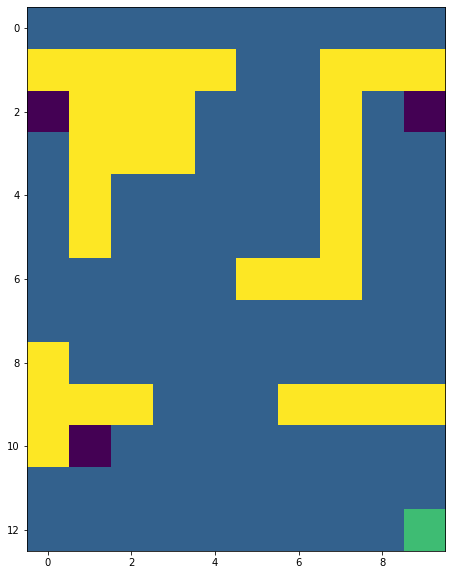

Results of the DP agent:



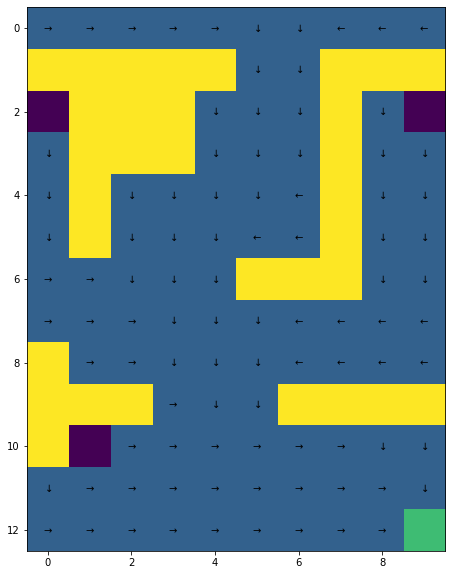

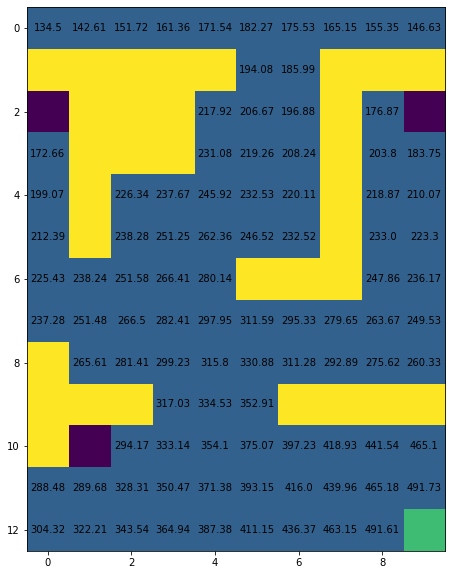

100%|██████████| 2000/2000 [00:54<00:00, 36.43it/s] 


Results of the MC agent:



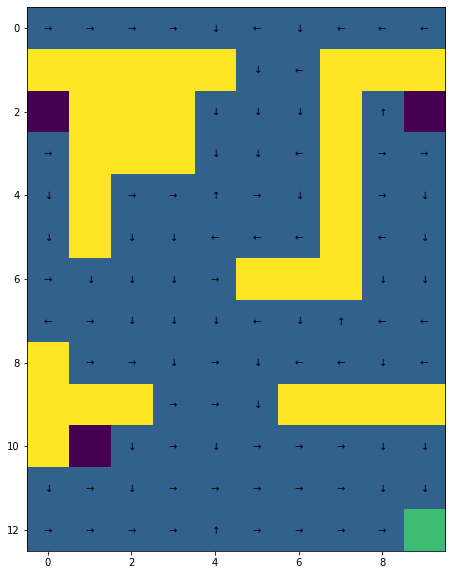

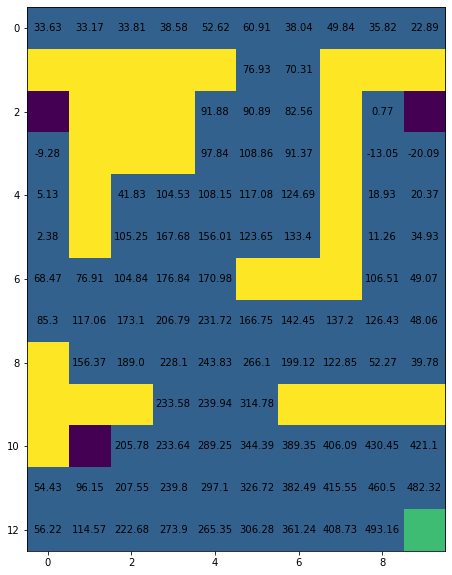

100%|██████████| 2000/2000 [00:17<00:00, 114.12it/s]


Results of the TD agent:



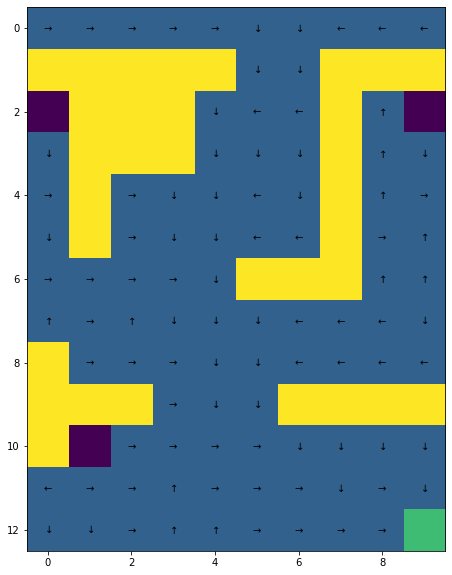

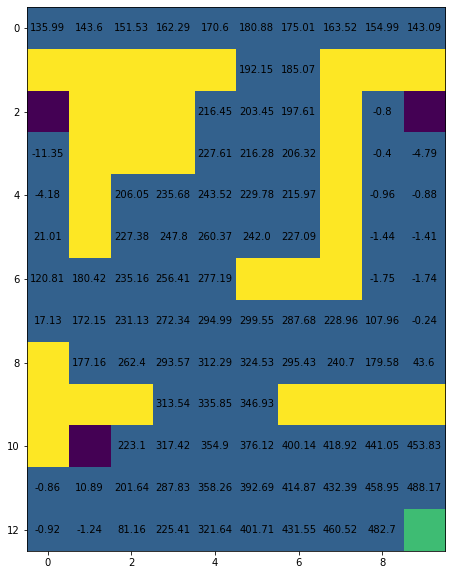

Creating new Maze:



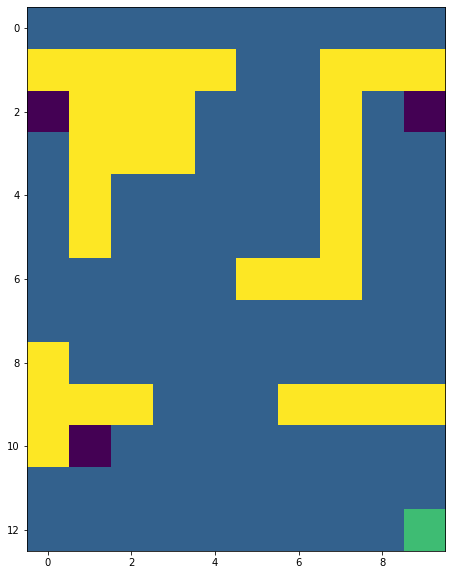

100%|██████████| 500/500 [00:01<00:00, 332.21it/s]


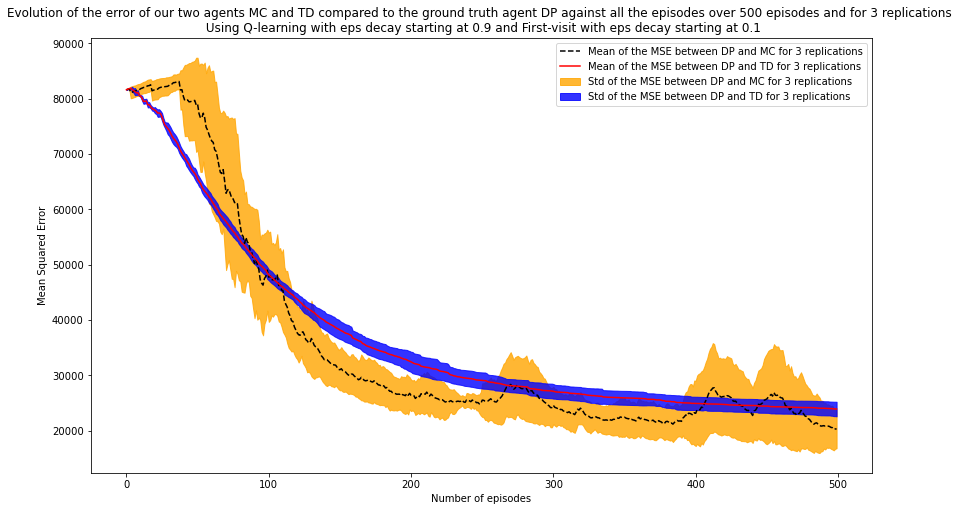

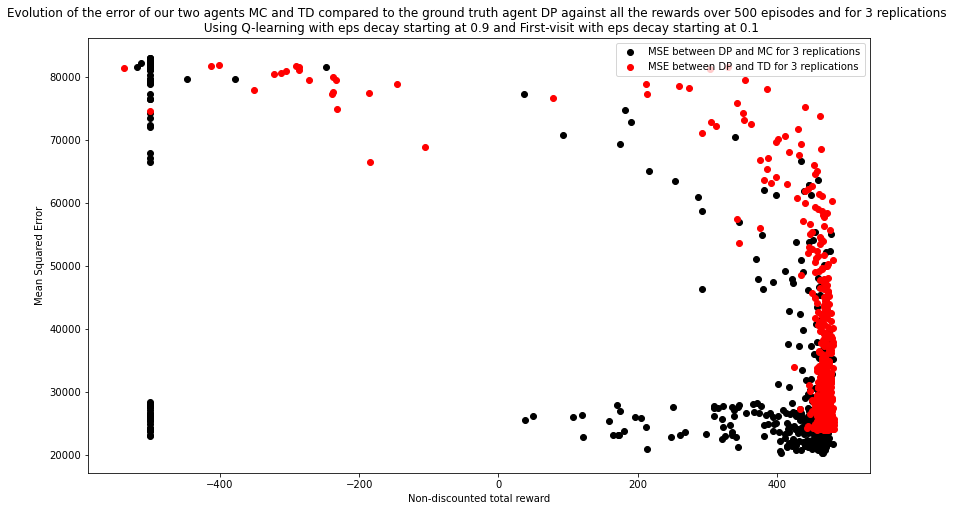

In [8]:
# Example main (can be edited)

# ## Question 0: Defining the environment

print("Creating the Maze:\n")
maze = Maze()


### Question 1: Dynamic programming

dp_agent = DP_agent()
dp_policy, dp_value = dp_agent.solve(maze)

print("Results of the DP agent:\n")
maze.get_graphics().draw_policy(dp_policy)
maze.get_graphics().draw_value(dp_value)


### Question 2: Monte-Carlo learning

mc_agent = MC_agent()
mc_policy, mc_values, total_rewards = mc_agent.solve(maze)

print("Results of the MC agent:\n")
maze.get_graphics().draw_policy(mc_policy)
maze.get_graphics().draw_value(mc_values[-1])


### Question 3: Temporal-Difference learning

td_agent = TD_agent()
td_policy, td_values, total_rewards = td_agent.solve(maze)

print("Results of the TD agent:\n")
maze.get_graphics().draw_policy(td_policy)
maze.get_graphics().draw_value(td_values[-1])

###Question 4 : Comparion of learners

print("Creating new Maze:\n")
# Initialization of our world, agent and parameters
env = Maze()
dp_agent = DP_agent()
dp_policy, dp_value = dp_agent.solve(env)
state_size = env.get_state_size() # Number of states
action_size = env.get_action_size() # Number of actions
gamma = env.get_gamma() # Discount factor

# General parameters
N_sim = 40
N_ep = 2000
epsilon_end = 0.001
epsilon_limit = 0.1
fix_lr = 0.2 # Our fixed learning rate

# Parameters for MC-eps decay
epsilon_init_MC = 0.1

# Parameters for Q-eps decay
epsilon_init_TD = 0.9
subdiv_ep = 500 # Total number of steps for each episode (fixed)

# Initializing our final results lists of mean, std and mse
all_mean_MC = []
all_mean_TD = []
all_std_MC = []
all_std_TD = []
all_mse_MC = []
all_mse_TD = []

for sim in range(N_sim): # Looping over our replications
    
    # Initialization of MC Agent
    mc_agent = MC_agent()
    Q = np.random.rand(state_size, action_size) # Initialising state value function to random values
    V = np.zeros(state_size) # Initialising value function to 0
    policy = np.ones((state_size, action_size))/action_size
    total_rewards = [] # List to contain thecumulative successive reward of each episode 
    all_discounted_rewards = {} # Our dictionnary of returns (discounted reward)
    for current_state in range(state_size): # Looping over each state
        for action in range(action_size): # Looping over each action
            all_discounted_rewards[current_state, action] = [] # Initializing the value of our returns dictionnary
    values = [V] # List of successive value functions for each episode
    
    best_policy_MC, best_values_MC, best_total_rewards_MC, best_mse_MC = mc_agent.MC_first_visit_eps_decay(env, N_ep, V, Q, policy, gamma, fix_lr, total_rewards, state_size, action_size, all_discounted_rewards, values, epsilon_init_MC, epsilon_end, epsilon_limit)              
    all_mse_MC.append(best_mse_MC)
        
    # Initialization of TD Agent
    td_agent = TD_agent()
    total_rewards = [] # List to contain thecumulative successive reward of each episode 
    Q = np.random.rand(state_size, action_size) # Initialising state value function to 0
    V = np.zeros(state_size) # Initialising value function to 0
    policy = np.zeros((state_size, action_size)) # Initialising policy to 0
    values = [V] # List of successive value functions for each episode
    
    best_policy_TD, best_values_TD, best_total_rewards_TD, best_mse_TD = td_agent.q_learning_eps_decay(env, fix_lr, N_ep, subdiv_ep, action_size, state_size, gamma, total_rewards, Q, V, policy, values, epsilon_init_TD, epsilon_end, epsilon_limit)
    all_mse_TD.append(best_mse_TD)
    
for ep in range(N_ep): #Looping over our episodes
    
    # Initializing our the mean
    ep_mean_MC = 0
    ep_mean_TD = 0
    ep_std_MC = []
    ep_std_TD = []
    
    for sim in range(N_sim): # Looping over our replications
        
        ep_mean_MC += all_mse_MC[sim][ep]
        ep_mean_TD += all_mse_TD[sim][ep]
        ep_std_MC.append(all_mse_MC[sim][ep])
        ep_std_TD.append(all_mse_TD[sim][ep])
        
    all_mean_MC.append(ep_mean_MC/N_sim) # Averaging
    all_mean_TD.append(ep_mean_TD/N_sim) # A
    all_std_MC.append(np.std(ep_std_MC))
    all_std_TD.append(np.std(ep_std_TD)) 
    
all_episodes = np.arange(0, N_ep, 1, dtype = float)
all_mean_MC = np.array(all_mean_MC)
all_mean_TD = np.array(all_mean_TD)
all_std_MC = np.array(all_std_MC)
all_std_TD = np.array(all_std_TD)
    
plt.figure(figsize = (14,8))
plt.plot(all_mean_MC, label = f"Mean of the MSE between DP and MC for {N_sim} replications", color='black', linestyle='dashed')
plt.plot(all_mean_TD, label = f"Mean of the MSE between DP and TD for {N_sim} replications", color='red')
plt.fill_between(all_episodes, all_mean_MC - all_std_MC,  all_mean_MC + all_std_MC, label = f"Std of the MSE between DP and MC for {N_sim} replications", alpha = 0.8, color='orange')
plt.fill_between(all_episodes, all_mean_TD - all_std_TD,  all_mean_TD + all_std_TD, label = f"Std of the MSE between DP and TD for {N_sim} replications", alpha = 0.8, color='blue')
plt.legend(loc = 'upper right')
plt.xlabel("Number of episodes")
plt.ylabel("Mean Squared Error")
plt.title(f"Evolution of the error of our two agents MC and TD compared to the ground truth agent DP against all the episodes over {N_ep} episodes and for {N_sim} replications \n Using Q-learning with eps decay starting at {epsilon_init_TD} and First-visit with eps decay starting at {epsilon_init_MC}")
plt.show()

plt.figure(figsize = (14,8))
plt.scatter(best_total_rewards_MC, all_mean_MC, color = 'black', label = f'MSE between DP and MC for {N_sim} replications')
plt.scatter(best_total_rewards_TD, all_mean_TD, color = 'red', label = f'MSE between DP and TD for {N_sim} replications')
plt.legend(loc = 'upper right')
plt.xlabel("Non-discounted total reward")
plt.ylabel("Mean Squared Error")
plt.title(f"Evolution of the error of our two agents MC and TD compared to the ground truth agent DP against all the rewards over {N_ep} episodes and for {N_sim} replications \n Using Q-learning with eps decay starting at {epsilon_init_TD} and First-visit with eps decay starting at {epsilon_init_MC}")
plt.show()